In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


## 1. Import Libraries

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

## 2. Import Datasets

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')
train.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


## 3. Data Cleaning

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.5 KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             730 non-null    int64  
 1   day            730 non-null    int64  
 2   pressure       730 non-null    float64
 3   maxtemp        730 non-null    float64
 4   temparature    730 non-null    float64
 5   mintemp        730 non-null    float64
 6   dewpoint       730 non-null    float64
 7   humidity       730 non-null    float64
 8   cloud          730 non-null    float64
 9   sunshine       730 non-null    float64
 10  winddirection  729 non-null    float64
 11  windspeed      730 non-null    float64
dtypes: float64(10), int64(2)
memory usage: 68.6 KB


In [5]:
train.shape, test.shape

((2190, 13), (730, 12))

#### Some notes so far:

Before we continue, just a couple thoughts on the data. The id columns in both the train and test dataset are not meaningful for training our model so we will go ahead and drop both columns. That being said, the training dataset has 11 features and 1 target variable rainfall, the testing set has 11, which makes sense since it does not include the target. The info method on the datasets shows no missing values in the training set and just 1 in the testing set (winddirection). We will fix that by imputing with the mean. But just to be sure about the missing values, we will perform the isnull() method on both datasets.

In [7]:
train.isnull().sum()

id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64

In [9]:
test.isnull().sum()

id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        0
dtype: int64

In [10]:
# check for duplicated entries
train.duplicated().sum(), test.duplicated().sum()

(0, 0)

Now that our suspiscions have been confirmed, let's go ahead and drop the 'id' columns and impute the missing value.

In [11]:
train = train.drop(columns=['id'])
test = test.drop(columns=['id'])
train.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


### More notes:

- Time Period: Data spans 2190 days (~6 years).
- Pressure: Ranges from 999 to 1034.6 hPa, with an average of 1013.6 hPa..
- Temperature Metrics:Max: 10.4°C to 36°C (Avg: 26.37°C),Min: 4°C to 29.8°C (Avg: 22.17°C),Mean Temp: 7.4°C to 31.5°C (Avg: 23.95°C)
- Dew Point: Varies from -0.3°C to 26.7°C (Avg: 20.45°C).Humidity: High overall, ranging from 39% to 98% (Avg: 82%).
- Cloud Cover: 2% to 100% (Avg: 75.7%).Sunshine Hours: 0 to 12.1 hours per day (Avg: 3.74 hours).
- Wind Direction: Highly variable, from 10° to 300° (Avg: 104.86°).Wind Speed: 4.4 km/h to 59.5 km/h (Avg: 21.8 km/h).
- Rainfall: Mostly binary (0 or 1), indicating dry or rainy days (Avg: 0.75).There are no null and categorical datatype in datasetv

## 4. EDA

In [12]:
numerical_variables = ['winddirection', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'windspeed']
target_variable = 'rainfall' 
categorical_variables = []

train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()

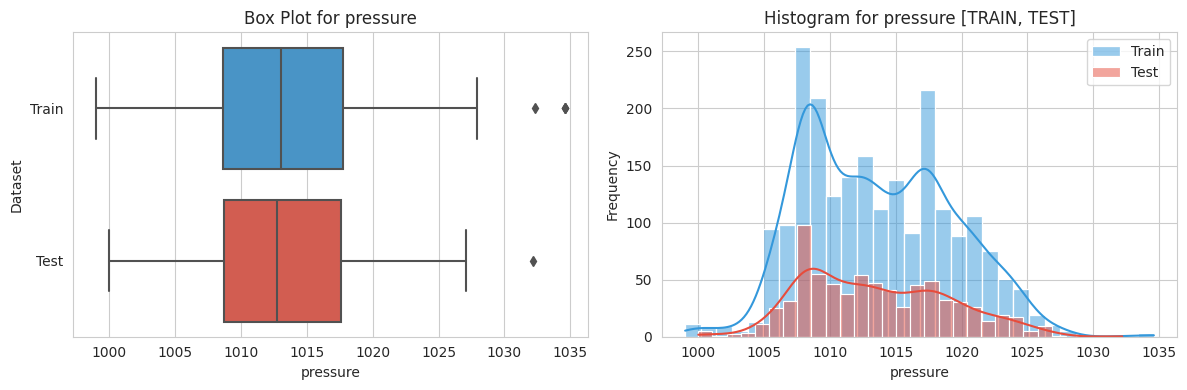

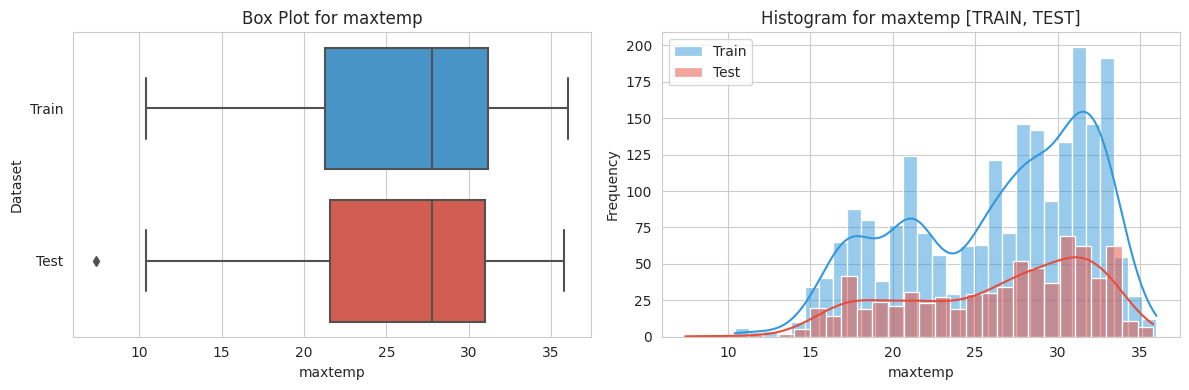

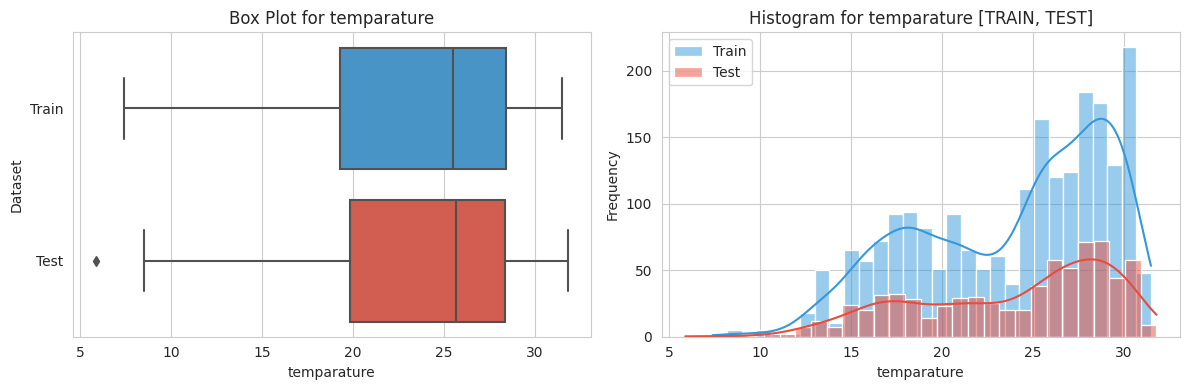

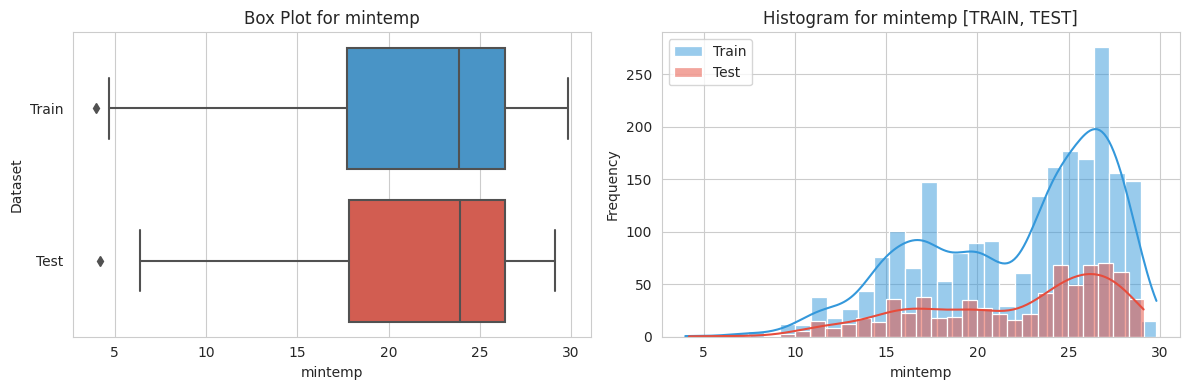

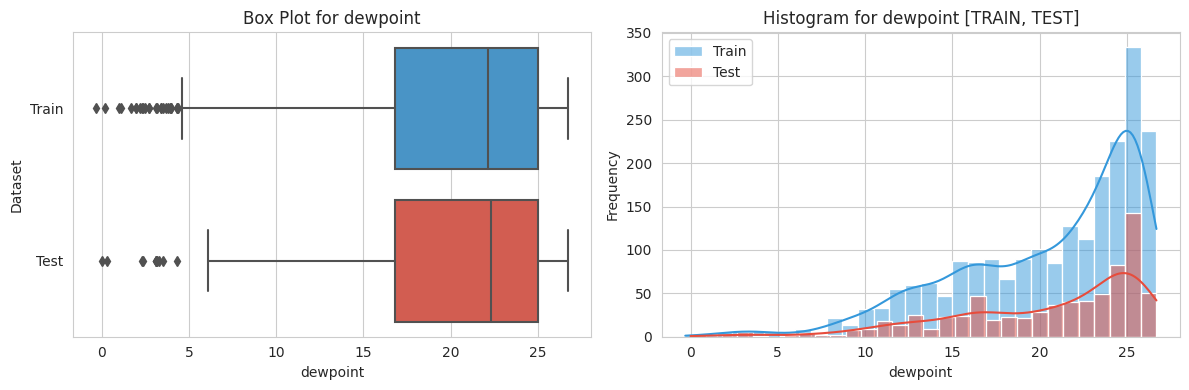

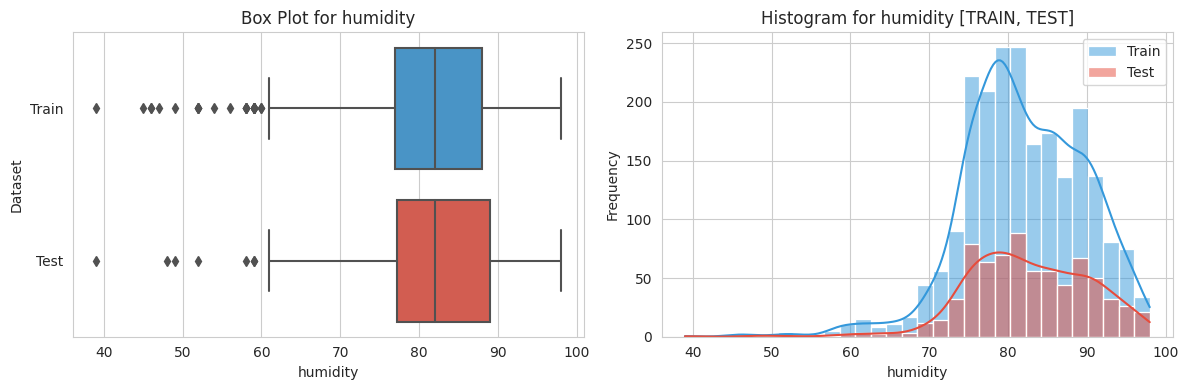

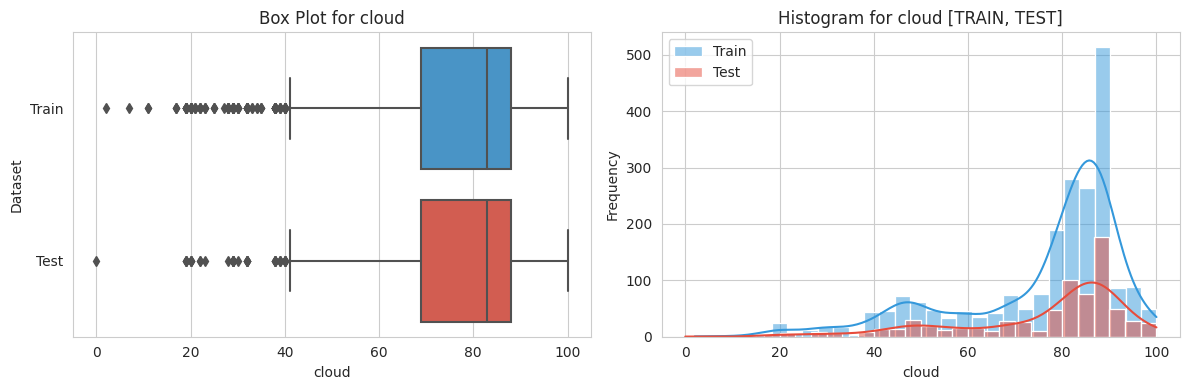

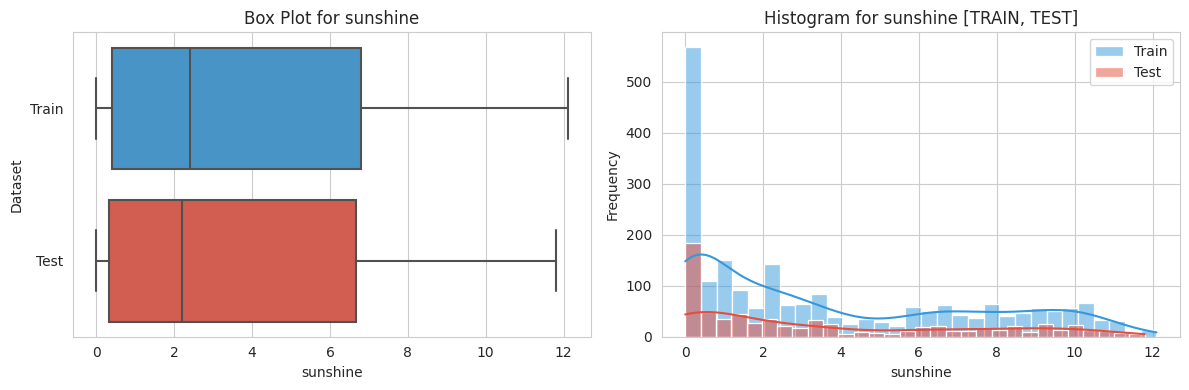

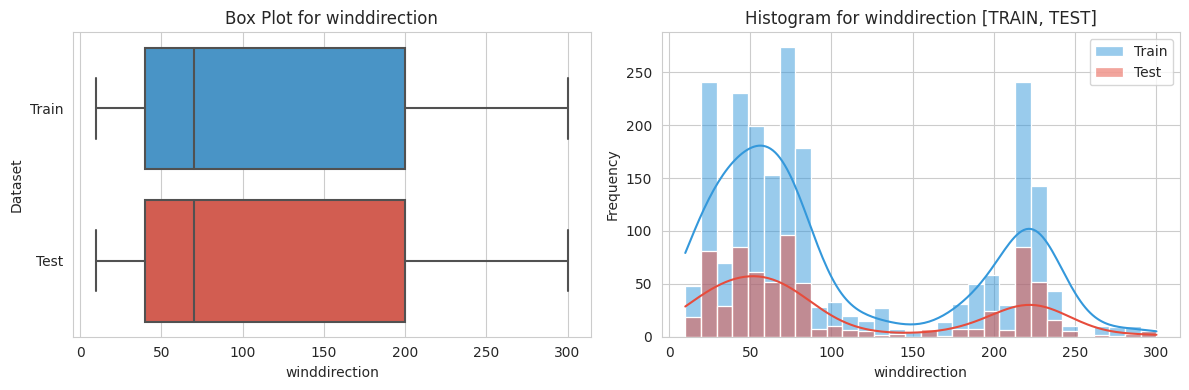

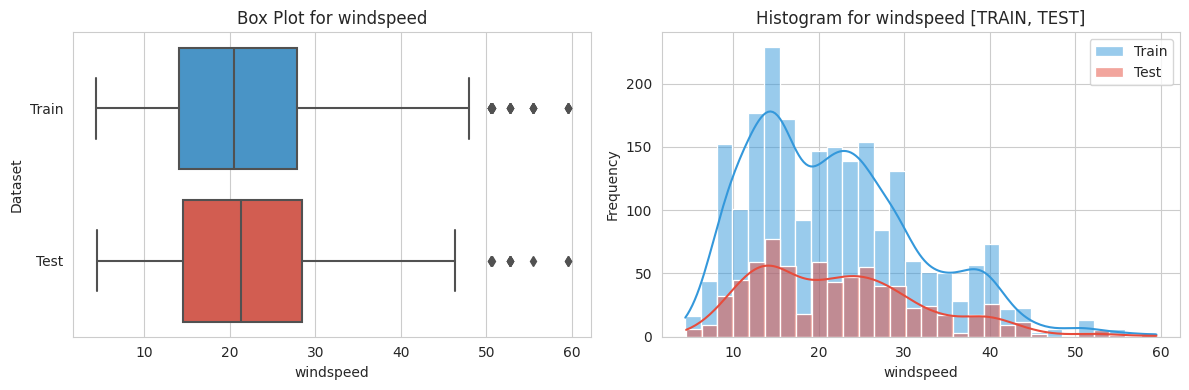

In [19]:
# Analysis of all NUMERICAL features

# Define a custom color palette
custom_palette = ['#3498db', '#e74c3c','#2ecc71']

# Add 'Dataset' column to distinguish between train and test data
train['Dataset'] = 'Train'
test['Dataset'] = 'Test'

variables = [col for col in train.columns if col in numerical_variables]

# Function to create and display a row of plots for a single variable
def create_variable_plots(variable):
    sns.set_style('whitegrid')
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Box plot
    plt.subplot(1, 2, 1)
    sns.boxplot(data=pd.concat([train, test]), x=variable, y
    ="Dataset", palette=custom_palette)
    plt.xlabel(variable)
    plt.title(f"Box Plot for {variable}")

    # Separate Histograms
    plt.subplot(1, 2, 2)
    sns.histplot(data=train, x=variable, color=custom_palette[0], kde=True, bins=30, label="Train")
    sns.histplot(data=test, x=variable, color=custom_palette[1], kde=True, bins=30, label="Test")
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title(f"Histogram for {variable} [TRAIN, TEST]")
    plt.legend()

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plots
    plt.show()

# Perform univariate analysis for each variable
for variable in variables:
    create_variable_plots(variable)

In [20]:
# Drop the 'Dataset' column after analysis
train.drop('Dataset', axis=1, inplace=True)
test.drop('Dataset', axis=1, inplace=True)

### Notes on EDA so far:

Looks like out data is rightly skewed and contains some outliers. 

We should think about applying some transformations to our features to make them look more like a normal distribution.

Let's look at how the features are correlated to the target variable.

<Axes: >

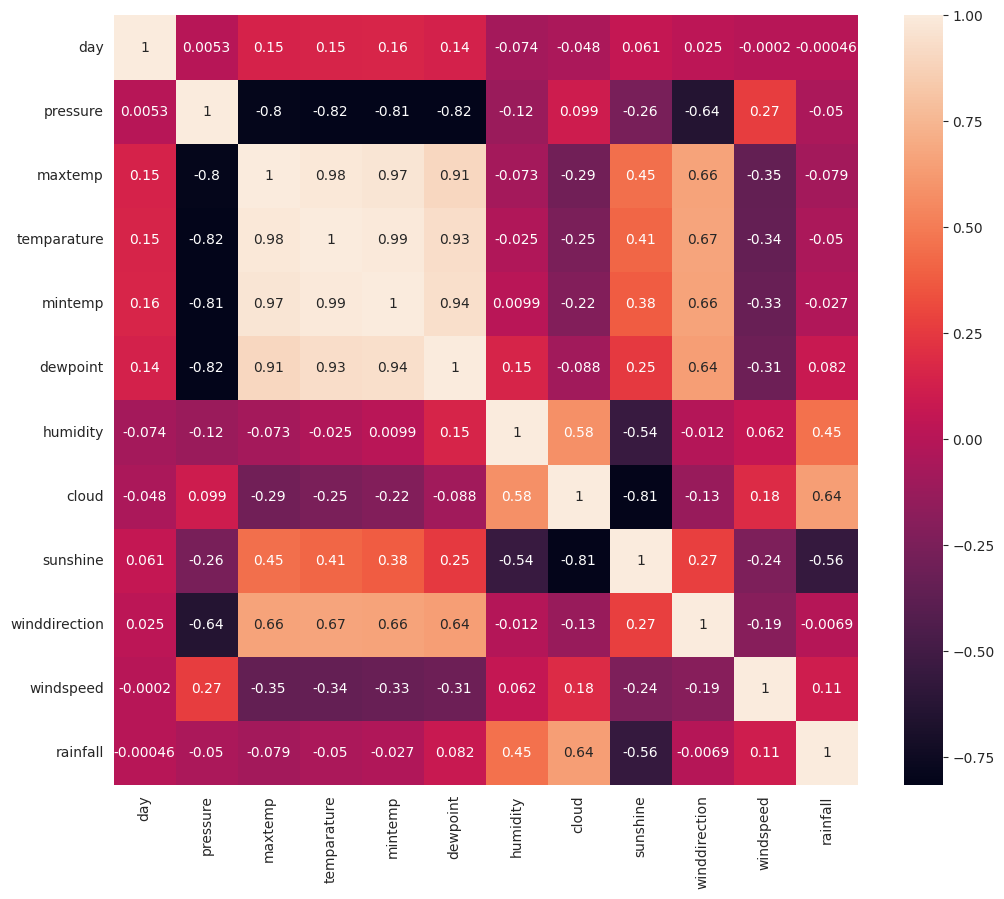

In [23]:
plt.figure(figsize=(12, 10))
sns.heatmap(train.corr(), annot=True)

### Correlation Insights: 

Pressure & Temperature have a strong negative correlation (-0.80 to -0.82) → Higher pressure is associated with lower temperatures.Max Temp, Avg Temp, Min Temp, and Dew Point are highly correlated (0.90 - 0.99) → Redundant information among these variables. Cloud Cover & Sunshine are strongly negatively correlated (-0.81) → More clouds mean less sunshine. Cloud Cover & Rainfall have a strong positive correlation (0.64) → More clouds generally lead to more rain. Wind Direction & Temperature (0.66 correlation) → Wind patterns significantly influence temperature. Humidity & Cloud Cover (0.58 correlation) → Higher humidity is associated with more cloud formation. Sunshine & Rainfall (-0.55 correlation) → More sunshine means less rainfall, which aligns with general weather patterns.

Multicollinearity Issues: Severe multicollinearity exists among temperature-related features (MaxTemp, Temp, MinTemp, DewPoint) → May cause instability in regression models. Pressure’s strong negative correlation with temperature variables (-0.80+) suggests it might be redundant in models including temperature.

## 5. Feature Engineering

In [27]:
data = train.copy()
data['season'] = data['day'] % 365

def get_season(day):
    month = (day % 365) // 30 + 1
    if month in [12, 1, 2]:
        return 0 #'Winter'
    elif month in [3, 4, 5]:
        return 1 #'Spring'
    elif month in [6, 7, 8]:
        return 2 #'Summer'
    else:
        return 3 #'Autumn'

data['season'] = data['day'].apply(get_season)
# data = pd.get_dummies(data, columns=['season'], dtype=int)
data.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,season
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1,0
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1,0
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1,0
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1,0
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0,0


In [28]:
data['day_of_year'] = data['day'] % 365
data['sin_day'] = np.sin(2 * np.pi * data['day_of_year'] / 365)
data['cos_day'] = np.cos(2 * np.pi * data['day_of_year'] / 365)

data.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,season,day_of_year,sin_day,cos_day
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1,0,1,0.017213,0.999852
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1,0,2,0.034422,0.999407
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1,0,3,0.051620,0.998667
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1,0,4,0.068802,0.997630
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0,0,5,0.085965,0.996298


In [29]:
data['temp_range'] = data['maxtemp'] - data['mintemp']
data['temp_dew_diff'] = data['temparature'] - data['dewpoint']

data['humid_temp'] = data['humidity'] * data['temparature']
data['cloud_sun_ratio'] = data['cloud'] / (data['sunshine'] + 1)

data['wind_speed_category'] = pd.cut(data['windspeed'], bins=[0, 10, 20, 30, 50, 100], labels=[1, 2, 3, 4, 5])
data['wind_speed_category'] = data['wind_speed_category'].astype('int')

# data['rainfall_lag1'] = data['rainfall'].shift(1).fillna(0)
# data['rainfall_lag3'] = data['rainfall'].shift(3).fillna(0)

data.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,...,rainfall,season,day_of_year,sin_day,cos_day,temp_range,temp_dew_diff,humid_temp,cloud_sun_ratio,wind_speed_category
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,...,1,0,1,0.017213,0.999852,1.3,1.2,1792.2,41.904762,2
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,...,1,0,2,0.034422,0.999407,0.4,1.5,1605.5,91.000000,3
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,...,1,0,3,0.051620,0.998667,4.8,6.8,1207.5,5.053763,2
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,...,1,0,4,0.068802,0.997630,1.2,1.0,1691.0,95.000000,4
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,...,0,0,5,0.085965,0.996298,6.1,8.8,956.8,9.782609,3


In [30]:
drop_cols = ['day', 'day_of_year', 'maxtemp',]
data.drop(columns=drop_cols, inplace=True)

## 6. Model Selection

In [31]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('rainfall', axis=1), data['rainfall'], 
                                                    stratify=data['rainfall'], random_state=42)

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc_cols  = ['pressure', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed', 'humid_temp',	'cloud_sun_ratio']
X_train[sc_cols] = sc.fit_transform(X_train[sc_cols])
X_test[sc_cols] = sc.transform(X_test[sc_cols])

X_train.head()

,pressure,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,season,sin_day,cos_day,temp_range,temp_dew_diff,humid_temp,cloud_sun_ratio,wind_speed_category
414,0.897490,20.2,-0.571313,-0.182970,-0.513455,0.735788,-0.039312,-0.173707,-0.517974,0,0.758306,0.651899,4.1,0.8,-0.858762,-0.527706,2
915,-1.048679,30.1,1.287086,1.040384,-0.891749,-1.737592,1.884298,0.951432,-1.102014,2,-0.060213,-0.998186,4.7,4.2,0.669905,-1.020471,2
1746,-0.120231,25.9,0.377657,0.532222,-0.261258,0.296076,-0.753796,-0.423738,-0.598531,3,-0.974100,0.226116,4.7,2.7,0.254055,0.142384,2
1247,-1.066534,30.4,1.227775,0.946280,-1.017848,-1.627664,1.801857,1.076448,-0.286372,2,0.486273,-0.873807,3.7,5.0,0.652195,-1.011674,2
1704,0.201154,28.0,0.871912,0.833355,-1.017848,-1.627664,1.059893,-0.673768,-0.930830,3,-0.880012,-0.474951,5.4,3.2,0.254055,-0.971186,2


In [39]:
models = {
    'Logistic_Reg' : LogisticRegression(),
    'SVC' : LinearSVC(),
    'DT' : DecisionTreeClassifier(),
    'RF' : RandomForestClassifier(),
    'XGB': XGBClassifier(),
    'Cat' : CatBoostClassifier(verbose=0),
    'LGB': LGBMClassifier(verbose=0),
}

In [44]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = {}

for name, model in models.items():
    scores = cross_val_score(model, data.drop('rainfall', axis=1), data['rainfall'], cv=cv, scoring="roc_auc")
    cv_scores[name] = scores
    print(f"{name}: Mean ROC-AUC = {np.mean(scores):.4f}, Std Dev = {np.std(scores):.4f}")

print("\nDetailed Scores:")
for name, scores in cv_scores.items():
    print(f"{name}: {scores}")

Logistic_Reg: Mean ROC-AUC = 0.8937, Std Dev = 0.0222
SVC: Mean ROC-AUC = 0.8892, Std Dev = 0.0213
DT: Mean ROC-AUC = 0.7309, Std Dev = 0.0203
RF: Mean ROC-AUC = 0.8760, Std Dev = 0.0252
XGB: Mean ROC-AUC = 0.8700, Std Dev = 0.0256
Cat: Mean ROC-AUC = 0.8859, Std Dev = 0.0254
LGB: Mean ROC-AUC = 0.8682, Std Dev = 0.0241

Detailed Scores:
Logistic_Reg: [0.92281145 0.86212121 0.8773569  0.91234568 0.89363075]
SVC: [0.91517957 0.86113917 0.8694725  0.90959596 0.89037598]
DT: [0.73703704 0.72988215 0.69292929 0.74368687 0.75117845]
RF: [0.91395903 0.8457211  0.85140292 0.89010943 0.87881594]
XGB: [0.9092312  0.83632155 0.84866723 0.88075196 0.87480359]
Cat: [0.91938833 0.84918631 0.86649832 0.90541526 0.88877666]
LGB: [0.90025253 0.83336139 0.84985971 0.88560606 0.87174523]


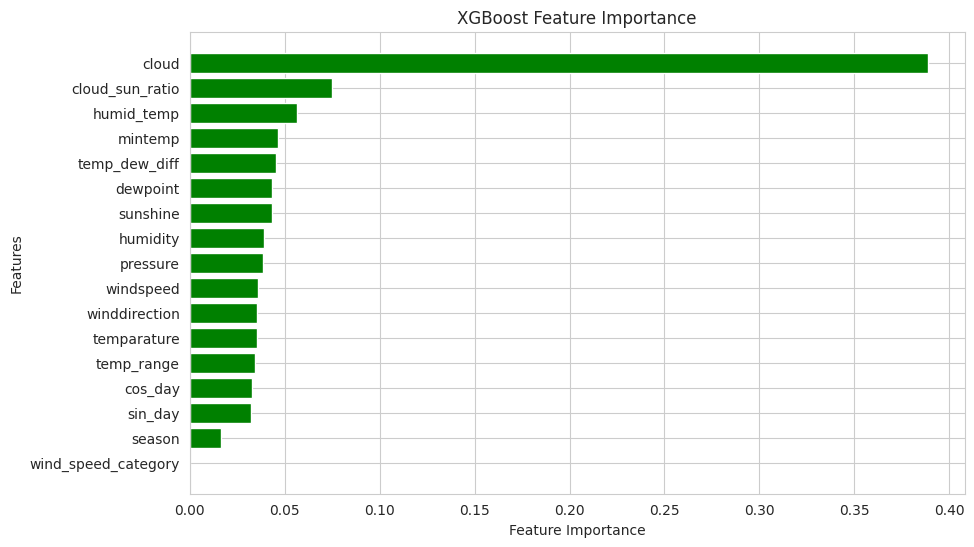

In [45]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

importances = xgb.feature_importances_
columns = X_train.columns

sorted_idx = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.barh(y=np.array(columns)[sorted_idx], width=importances[sorted_idx], color="green")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.show()

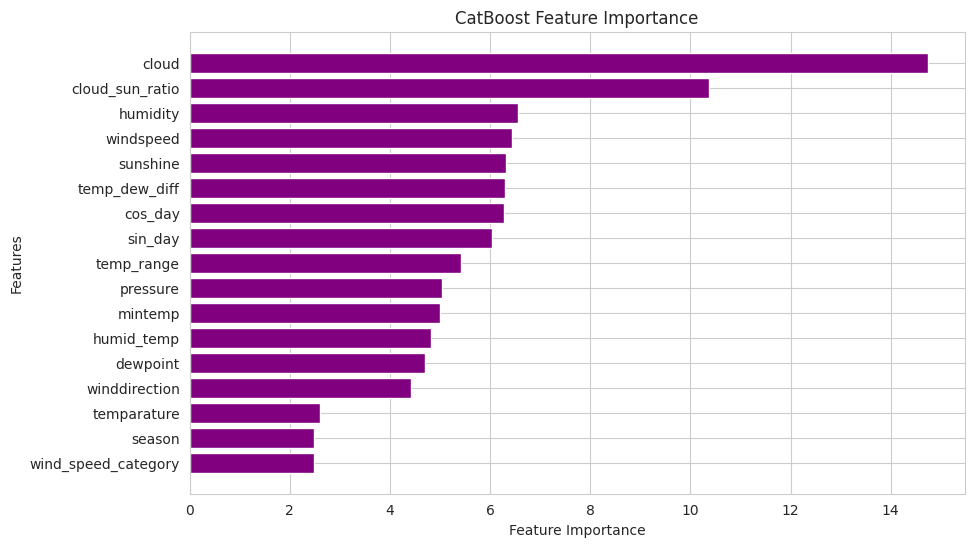

In [46]:
cat = CatBoostClassifier(verbose=0)
cat.fit(X_train, y_train)

importances = cat.feature_importances_
columns = X_train.columns

sorted_idx = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.barh(y=np.array(columns)[sorted_idx], width=importances[sorted_idx], color="purple")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("CatBoost Feature Importance")
plt.show()

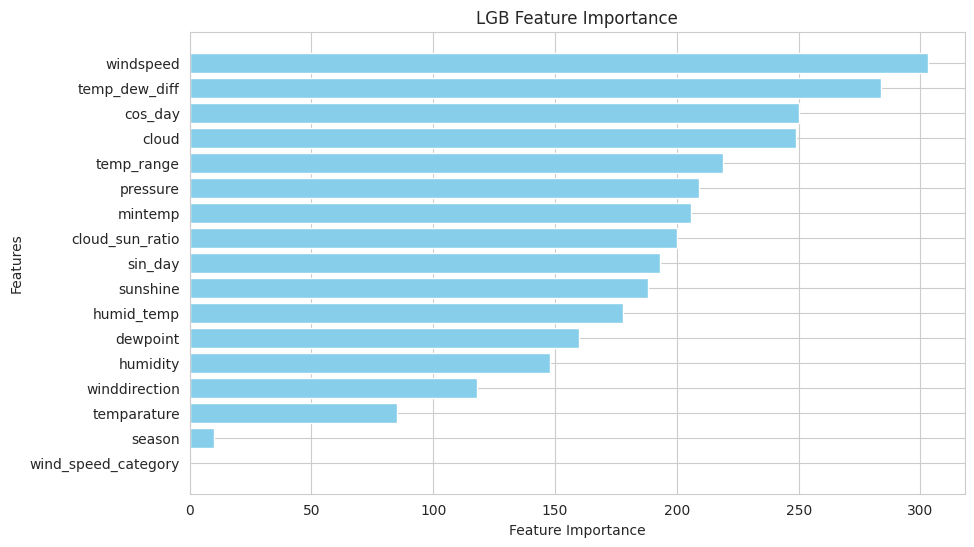

In [47]:
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)

importances = lgb.feature_importances_
columns = X_train.columns

sorted_idx = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.barh(y=np.array(columns)[sorted_idx], width=importances[sorted_idx], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("LGB Feature Importance")
plt.show()

## 7. Logistic Regression

In [49]:
model = LogisticRegression()
model.fit(X_train, y_train)
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

0.8884046273876782

In [51]:
model.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))

LogisticRegression()

In [55]:
def process_test(data:pd.DataFrame):
    data['season'] = data['day'].apply(get_season)
    
    data['day_of_year'] = data['day'] % 365
    data['sin_day'] = np.sin(2 * np.pi * data['day_of_year'] / 365)
    data['cos_day'] = np.cos(2 * np.pi * data['day_of_year'] / 365)

    data['temp_range'] = data['maxtemp'] - data['mintemp']
    data['temp_dew_diff'] = data['temparature'] - data['dewpoint']

    data['humid_temp'] = data['humidity'] * data['temparature']
    data['cloud_sun_ratio'] = data['cloud'] / (data['sunshine'] + 1)
    # print(data.head())

    data['wind_speed_category'] = pd.cut(data['windspeed'], bins=[0, 10, 20, 30, 50, 100], labels=[1, 2, 3, 4, 5])
    data['wind_speed_category'] = data['wind_speed_category'].astype('int')
    
    # data['rainfall_lag1'] = data['rainfall'].shift(1).fillna(0)
    # data['rainfall_lag3'] = data['rainfall'].shift(3).fillna(0)
    drop_cols = ['day', 'day_of_year', 'maxtemp',]
    data.drop(columns=drop_cols, inplace=True)
    data[sc_cols] = sc.transform(data[sc_cols])
    
    data.fillna(0, inplace=True, axis=0)
    return data

In [53]:
test = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv').set_index('id')

In [56]:
test = process_test(test)
test.head()

,pressure,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,season,sin_day,cos_day,temp_range,temp_dew_diff,humid_temp,cloud_sun_ratio,wind_speed_category
id,,,,,,,,,,,,,,,,,
2190,1.040328,15.8,-1.856376,-1.029908,1.756313,1.285428,-1.028598,-0.673768,0.247320,0,0.017213,0.999852,4.8,0.9,-0.990579,1.995632,3
2191,0.504685,16.5,-1.243500,-0.992266,1.882411,1.285428,-1.028598,-0.673768,1.354981,0,0.034422,0.999407,1.7,1.4,-0.802942,1.995632,4
2192,1.825938,10.4,-2.508793,-2.159158,0.495331,1.120536,-1.028598,-0.798784,-0.497834,0,0.051620,0.998667,1.8,1.5,-2.385860,1.900594,2
2193,1.647390,17.3,-1.362121,-2.046233,-0.891749,-1.682628,0.922493,-1.048815,2.895638,0,0.068802,0.997630,5.4,7.8,-1.482200,-0.964638,5
2194,1.522407,13.8,-3.101899,-3.024917,-1.774437,-1.462772,1.499576,-1.048815,-0.246093,0,0.085965,0.996298,9.7,9.5,-2.287222,-0.988449,2


## 8. Submission

In [59]:
submission = model.predict_proba(test)[:, 1]
subfile = pd.read_csv('/kaggle/input/playground-series-s5e3/sample_submission.csv')
subfile['rainfall'] = submission

subfile.to_csv('submission.csv', index=False)

subfile.head()

,id,rainfall
0,2190,0.986795
1,2191,0.987505
2,2192,0.940849
3,2193,0.087431
4,2194,0.047094
